# Chapter III: Separable PINNs - Computational Efficiency

Numerical verification of SPINN computational costs from Section~\ref{sec:III1_SeparablePINNs}.

In [8]:
import os, time
import numpy as np
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'grid'])

import deepxde as dde
import jax
import jax.numpy as jnp

from phd.config import get_current_config, book_config
book_config.set_as_current()
page_width = get_current_config().page_width

results_folder = '../results/III_SeparablePINNs'
save_fig = True

In [9]:
# Network setup: comparable architectures
d, m, n_hidden, width, rank = 2, 2, 3, 32, 16

# SPINN: d body-networks (1D → r*m features)
spinn_layers = [d] + [width] * (n_hidden-1) + [rank] + [m]
spinn_net = dde.nn.SPINN(spinn_layers, "tanh", "Glorot uniform")
spinn_net.params = spinn_net.init(jax.random.PRNGKey(0), [jnp.ones((1,1)) for _ in range(d)])

# PFNN: m parallel subnetworks
pfnn_layers = [d] + [[width] * m] * n_hidden + [m]
pfnn_net = dde.nn.PFNN(pfnn_layers, "tanh", "Glorot uniform")
pfnn_net.params = pfnn_net.init(jax.random.PRNGKey(0), jnp.ones((1, d)))

count_params = lambda net: sum(jax.tree_util.tree_leaves(jax.tree_util.tree_map(lambda x: x.size, net.params)))
print(f"Parameters - SPINN: {count_params(spinn_net):,}, PFNN: {count_params(pfnn_net):,}")

Parameters - SPINN: 4,352, PFNN: 4,482


### Forward Pass FLOPs

PFNN processes $N^d$ points → $\mathcal{O}(N^d)$. SPINN: $d$ body-networks on $N$ points + merging → between $\mathcal{O}(N)$ and $\mathcal{O}(N^d)$.

Forward speedup at N=256: 89.1x


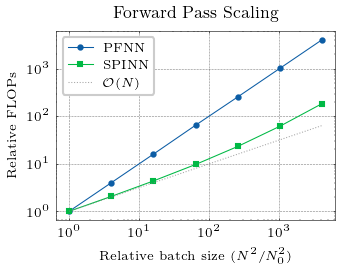

In [35]:
def estimate_flops(net, net_type, n):
    X = jnp.ones((n**2, d)) if net_type == "PFNN" else [jnp.ones((n, 1)) for _ in range(d)]
    compiled = jax.jit(lambda x: net.apply(net.params, x)).lower(X).compile()
    return compiled.cost_analysis()['flops']

batch_sizes = [4, 8, 16, 32, 64, 128, 256]
pfnn_fwd = [estimate_flops(pfnn_net, "PFNN", n) for n in batch_sizes]
spinn_fwd = [estimate_flops(spinn_net, "SPINN", n) for n in batch_sizes]
total_points = [n**2 for n in batch_sizes]

# Plot forward pass scaling
fig, ax = plt.subplots(figsize=(page_width/2, page_width/2.5), dpi=150)
pfnn_norm = np.array(pfnn_fwd) / pfnn_fwd[0]
spinn_norm = np.array(spinn_fwd) / spinn_fwd[0]
pts_norm = np.array(total_points) / total_points[0]

ax.loglog(pts_norm, pfnn_norm, 'o-', label='PFNN')
ax.loglog(pts_norm, spinn_norm, 's-', label='SPINN')
ax.loglog(pts_norm, np.sqrt(pts_norm), ':', label=r'$\mathcal{O}(N)$', color='gray', alpha=0.7)
ax.set(xlabel='Relative batch size ($N^2/N^2_0$)', ylabel='Relative FLOPs', title='Forward Pass Scaling')
ax.legend()
plt.tight_layout()

print(f"Forward speedup at N={batch_sizes[-1]}: {pfnn_fwd[-1]/spinn_fwd[-1]:.1f}x")

### Gradient Computation FLOPs

Computing $\partial \hat{u}/\partial x_i$: SPINN only differentiates the $i$-th body-network with $N$ points (not $N^d$).

- **Forward-mode (jacfwd/jvp)**: $\mathcal{O}(d)$ passes — optimal when $d < m$
- **Reverse-mode (jacrev/grad)**: $\mathcal{O}(m)$ passes — optimal when $m < d$

In [25]:
# Gradient functions
def pfnn_jacrev(net, x):
    return jax.vmap(lambda xi: jax.jacrev(lambda xin: net.apply(net.params, xin[None,:])[0])(xi))(x)

def pfnn_jacfwd(net, x):
    return jax.vmap(lambda xi: jax.jacfwd(lambda xin: net.apply(net.params, xin[None,:])[0])(xi))(x)

def spinn_jvp(net, x):
    _, df = jax.jvp(lambda x1: net.apply(net.params, [x1, x[1]]), (x[0],), (jnp.ones_like(x[0]),))
    return df

def spinn_grad(net, x):
    def grad_out(i): return jax.grad(lambda x1: net.apply(net.params, [x1, x[1]])[:, i].sum())(x[0])
    return jax.vmap(grad_out)(jnp.arange(m)).T

# Compare at N=256
n = 256
X_pfnn = jnp.ones((n**2, d))
X_spinn = [jnp.ones((n, 1)) for _ in range(d)]

def get_grad_flops(fn, X):
    return jax.jit(fn).lower(X).compile().cost_analysis()['flops']

grad_flops = {
    'PFNN jacrev': get_grad_flops(lambda x: pfnn_jacrev(pfnn_net, x), X_pfnn),
    'PFNN jacfwd': get_grad_flops(lambda x: pfnn_jacfwd(pfnn_net, x), X_pfnn),
    'SPINN grad': get_grad_flops(lambda x: spinn_grad(spinn_net, x), X_spinn),
    'SPINN jvp': get_grad_flops(lambda x: spinn_jvp(spinn_net, x), X_spinn),
}

print(f"Gradient FLOPs at N={n} (d={d} inputs, m={m} outputs):")
print("-" * 50)
for k, v in grad_flops.items():
    print(f"  {k:<15}: {v:>12,.0f}  ({grad_flops['PFNN jacrev']/v:>5.1f}x vs jacrev)")
print("-" * 50)
print(f"SPINN jvp vs PFNN jacfwd: {grad_flops['PFNN jacfwd']/grad_flops['SPINN jvp']:.1f}x speedup")

Gradient FLOPs at N=256 (d=2 inputs, m=2 outputs):
--------------------------------------------------
  PFNN jacrev    : 1,749,287,040  (  1.0x vs jacrev)
  PFNN jacfwd    : 1,731,985,920  (  1.0x vs jacrev)
  SPINN grad     :   12,295,680  (142.3x vs jacrev)
  SPINN jvp      :    6,897,664  (253.6x vs jacrev)
--------------------------------------------------
SPINN jvp vs PFNN jacfwd: 251.1x speedup


In [36]:
# Gradient FLOPs scaling (forward-mode only: optimal for both)
def grad_flops_scaling(net, net_type, n):
    if net_type == "PFNN":
        X = jnp.ones((n**2, d))
        fn = lambda x: pfnn_jacfwd(net, x)
    else:
        X = [jnp.ones((n, 1)) for _ in range(d)]
        fn = lambda x: spinn_jvp(net, x)
    return jax.jit(fn).lower(X).compile().cost_analysis()['flops']

pfnn_grad_flops = [grad_flops_scaling(pfnn_net, "PFNN", n) for n in batch_sizes]
spinn_grad_flops = [grad_flops_scaling(spinn_net, "SPINN", n) for n in batch_sizes]

print("Gradient FLOPs (forward-mode):")
for i, n in enumerate(batch_sizes):
    print(f"  N={n:3d}: PFNN={pfnn_grad_flops[i]:>12,.0f}, SPINN={spinn_grad_flops[i]:>10,.0f}, speedup={pfnn_grad_flops[i]/spinn_grad_flops[i]:.1f}x")

Gradient FLOPs (forward-mode):
  N=  4: PFNN=     423,368, SPINN=    43,264, speedup=9.8x
  N=  8: PFNN=   1,691,912, SPINN=    88,576, speedup=19.1x
  N= 16: PFNN=   6,913,544, SPINN=   185,344, speedup=37.3x
  N= 32: PFNN=  27,062,792, SPINN=   403,456, speedup=67.1x
  N= 64: PFNN= 108,249,608, SPINN=   937,984, speedup=115.4x
  N=128: PFNN= 432,996,864, SPINN= 2,400,256, speedup=180.4x
  N=256: PFNN=1,731,985,920, SPINN= 6,897,664, speedup=251.1x


### Timing Comparison

FLOPs don't capture all runtime factors. Timing benchmark confirms speedup.

In [39]:
from functools import partial

def time_fn(fn, runs=50):
    fn()  # compile
    times = []
    for _ in range(runs):
        t0 = time.perf_counter()
        jax.block_until_ready(fn())
        times.append(time.perf_counter() - t0)
    return np.median(times) * 1000

# Forward pass timing
pfnn_fwd_times, spinn_fwd_times = [], []
for n in batch_sizes:
    jax.clear_caches()
    X_p = jnp.ones((n**2, d))
    X_s = [jnp.ones((n, 1)) for _ in range(d)]
    pfnn_fwd_times.append(time_fn(jax.jit(partial(pfnn_net.apply, pfnn_net.params, X_p))))
    spinn_fwd_times.append(time_fn(jax.jit(partial(spinn_net.apply, spinn_net.params, X_s))))

# Gradient timing
pfnn_grad_times, spinn_grad_times = [], []
for n in batch_sizes:
    jax.clear_caches()
    X_p = jnp.ones((n**2, d))
    X_s = [jnp.ones((n, 1)) for _ in range(d)]
    pfnn_grad_times.append(time_fn(jax.jit(partial(pfnn_jacfwd, pfnn_net, X_p))))
    spinn_grad_times.append(time_fn(jax.jit(partial(spinn_jvp, spinn_net, X_s))))

print("Timing (ms):")
print(f"{'N':>5} {'PFNN fwd':>10} {'SPINN fwd':>10} {'fwd speedup':>12} {'PFNN grad':>10} {'SPINN grad':>11} {'grad speedup':>13}")
print("-" * 75)
for i, n in enumerate(batch_sizes):
    print(f"{n:>5} {pfnn_fwd_times[i]:>10.3f} {spinn_fwd_times[i]:>10.3f} {pfnn_fwd_times[i]/spinn_fwd_times[i]:>12.1f}x "
          f"{pfnn_grad_times[i]:>10.3f} {spinn_grad_times[i]:>11.3f} {pfnn_grad_times[i]/spinn_grad_times[i]:>13.1f}x")

Timing (ms):
    N   PFNN fwd  SPINN fwd  fwd speedup  PFNN grad  SPINN grad  grad speedup
---------------------------------------------------------------------------
    4      1.217      1.216          1.0x      1.217       1.225           1.0x
    8      1.218      1.303          0.9x      1.230       1.259           1.0x
   16      0.157      0.236          0.7x      1.340       1.243           1.1x
   32      0.153      0.178          0.9x      1.319       1.345           1.0x
   64      1.208      1.190          1.0x      1.307       1.259           1.0x
  128      1.220      1.222          1.0x      2.287       1.234           1.9x
  256      1.188      1.177          1.0x      8.650       1.195           7.2x


### Summary


At N=256 (65,536 points):
  Forward FLOPs speedup: 89.1x
  Gradient FLOPs speedup: 251.1x
  Forward time speedup: 1.0x
  Gradient time speedup: 7.2x


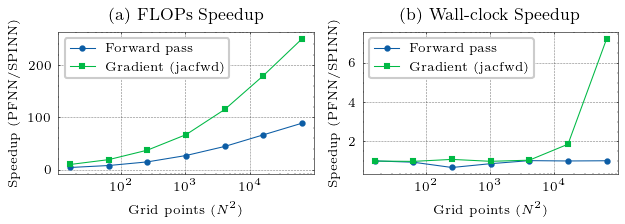

In [40]:
# Final comparison plot: FLOPs and Time speedups
fig, axes = plt.subplots(1, 2, figsize=(page_width*0.9, page_width/3), dpi=150)

# (a) FLOPs speedup
flops_fwd_speedup = [p/s for p, s in zip(pfnn_fwd, spinn_fwd)]
flops_grad_speedup = [p/s for p, s in zip(pfnn_grad_flops, spinn_grad_flops)]
axes[0].semilogx(total_points, flops_fwd_speedup, 'o-', label='Forward pass')
axes[0].semilogx(total_points, flops_grad_speedup, 's-', label='Gradient (jacfwd)')
axes[0].set(xlabel=r'Grid points ($N^2$)', ylabel='Speedup (PFNN/SPINN)', title='(a) FLOPs Speedup')
axes[0].legend()

# (b) Time speedup
time_fwd_speedup = [p/s for p, s in zip(pfnn_fwd_times, spinn_fwd_times)]
time_grad_speedup = [p/s for p, s in zip(pfnn_grad_times, spinn_grad_times)]
axes[1].semilogx(total_points, time_fwd_speedup, 'o-', label='Forward pass')
axes[1].semilogx(total_points, time_grad_speedup, 's-', label='Gradient (jacfwd)')
axes[1].set(xlabel=r'Grid points ($N^2$)', ylabel='Speedup (PFNN/SPINN)', title='(b) Wall-clock Speedup')
axes[1].legend()

plt.tight_layout()

if save_fig:
    os.makedirs(results_folder, exist_ok=True)
    fig.savefig(os.path.join(results_folder, "spinn_efficiency.pdf"), bbox_inches='tight')
    fig.savefig(os.path.join(results_folder, "spinn_efficiency.png"), bbox_inches='tight', dpi=300)

print(f"\nAt N={batch_sizes[-1]} ({total_points[-1]:,} points):")
print(f"  Forward FLOPs speedup: {flops_fwd_speedup[-1]:.1f}x")
print(f"  Gradient FLOPs speedup: {flops_grad_speedup[-1]:.1f}x")
print(f"  Forward time speedup: {time_fwd_speedup[-1]:.1f}x")
print(f"  Gradient time speedup: {time_grad_speedup[-1]:.1f}x")